# Anomaly detection
## Add all imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score

## Read data

In [2]:
train_df = pd.read_csv(r'resources\train_data.csv')
val_df = pd.read_csv(r'resources\val_data.csv')
test_df = pd.read_csv(r'resources\test_data.csv')


train_data = train_df[train_df.columns.difference(['Id', 'Label'])]
val_data = val_df[val_df.columns.difference(['Id', 'Label'])]
test_data = test_df[test_df.columns.difference(['Id'])]

train_no_time = train_df[train_df.columns.difference(['Id', 'Label', 'Timestamp'])]
val_no_time = val_df[val_df.columns.difference(['Id', 'Label', 'Timestamp'])]
test_no_time = test_df[test_df.columns.difference((['Id', 'Label', 'Timestamp']))]

## Correlation Matrix heatmap

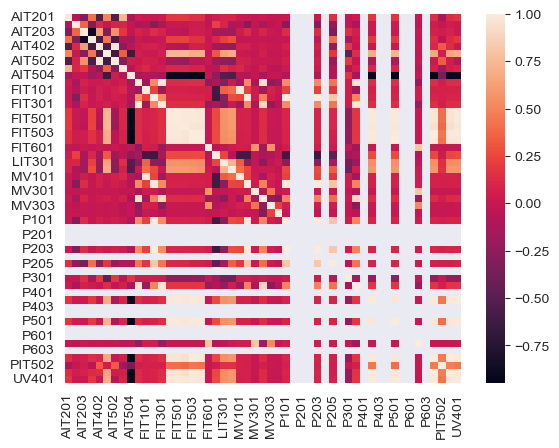

In [10]:
sns.heatmap(train_data.corr())
plt.show()

## Contamination


In [4]:
contamination_in_validation = np.count_nonzero(val_df['Label']) / len(val_df['Label'])
print(contamination_in_validation)

0.04905782831538191


## Scale data

In [3]:
scaler = StandardScaler()

train_no_time_scaled = scaler.fit_transform(train_no_time.to_numpy())
val_no_time_scaled = scaler.fit_transform(val_no_time.to_numpy())
test_no_time_scaled = scaler.fit_transform(test_no_time.to_numpy())


## Change timestamps into seconds

In [9]:

import datetime
import time

seconds_in_a_day= 86400
seconds_in_a_week= 604800

train_seconds = [time.mktime(datetime.datetime.strptime(x.strip(), "%d/%m/%Y %I:%M:%S %p").timetuple()) for x in
           train_data['Timestamp']]

start_epoch = np.min(train_seconds)

train_seconds = (train_seconds - start_epoch) #% seconds_in_a_week

val_seconds = [time.mktime(datetime.datetime.strptime(x.strip(), "%d/%m/%Y %I:%M:%S %p").timetuple()) for x in
           val_data['Timestamp']]
val_seconds = (val_seconds - start_epoch) #% seconds_in_a_week

test_seconds = [time.mktime(datetime.datetime.strptime(x.strip(), "%d/%m/%Y %I:%M:%S %p").timetuple()) for x in
           test_data['Timestamp']]
test_seconds = (test_seconds - start_epoch) #% seconds_in_a_week

train_with_seconds = train_data
train_with_seconds['Seconds'] = train_seconds
val_with_seconds = val_data
val_with_seconds['Seconds'] = val_seconds
test_with_seconds = test_data
test_with_seconds['Seconds'] = test_seconds


train_data_with_time = train_with_seconds[train_with_seconds.columns.difference(['Timestamp'])]
val_data_with_time = val_with_seconds[val_with_seconds.columns.difference(['Timestamp'])]
test_data_with_time = test_with_seconds[test_with_seconds.columns.difference(['Timestamp'])]

C:\Users\razva\AppData\Local\Temp\ipykernel_13580\149767880.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_with_seconds['Seconds'] = train_seconds
C:\Users\razva\AppData\Local\Temp\ipykernel_13580\149767880.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_with_seconds['Seconds'] = val_seconds


## Dimensionality reduction using PCA

### Look for all dimension

Text(0.5, 1.0, 'Scree Plot')

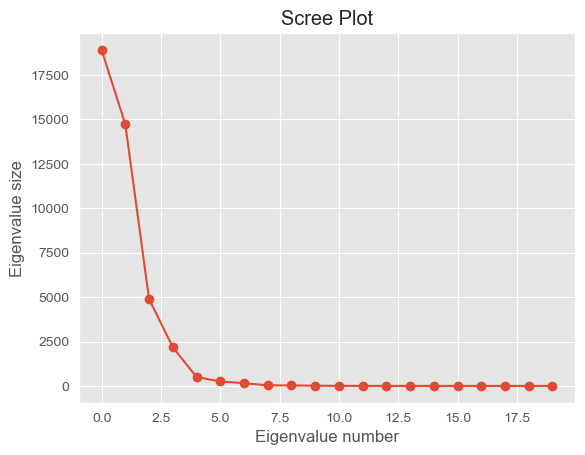

In [3]:
pca_test = PCA(n_components=20)
train_data_pc = pca_test.fit_transform(train_no_time)

plt.style.use("ggplot")
plt.plot(pca_test.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")


### Reduce dimensionality

In [15]:
pca = PCA(n_components=2)
train_no_time_pc = pca.fit_transform(train_no_time)
val_no_time_pc = pca.fit_transform(val_no_time)
test_no_time_pc = pca.fit_transform(test_no_time)

## Anomaly detection using Isolation forest

In [54]:
isolation_model = IsolationForest(random_state=42, n_estimators= 100, contamination= 0.0075).fit(train_data_with_time)

prediction_val_non_format = isolation_model.predict(val_data_with_time)
prediction_val = []
for x in prediction_val_non_format:
    if x == -1:
        prediction_val.append(1)
    else:
        prediction_val.append(0)
true_val = val_df["Label"]

score = f1_score(true_val, prediction_val, average='micro')
print(score)

C:\Users\razva\anaconda3\envs\startercode.0\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


0.9510666388097386


In [1]:
# 25 -> 0.9511555438991105
isolation_model_big = IsolationForest(random_state= 42, n_estimators= 100, contamination= 0.0065).fit(train_data_with_time)

prediction_val_non_format = isolation_model_big.predict(val_data_with_time)
prediction_val = []
for x in prediction_val_non_format:
    if x == -1:
        prediction_val.append(1)
    else:
        prediction_val.append(0)
true_val = val_df["Label"]

score = f1_score(true_val, prediction_val, average='micro')
print(score)

# Predict for test data

In [20]:
prediction_test_non_format = isolation_model_big.predict(test_data_with_time)

In [21]:
prediction_test = []
for i,x in enumerate(prediction_test_non_format):
    if x == -1:
        prediction_test.append([test_df.iloc[i, [0]]["Id"], 1])
    else:
        prediction_test.append([test_df.iloc[i, [0]]["Id"], 0])

df = pd.DataFrame(prediction_test, columns=['Id', 'Label'])
df.to_csv('prediction.csv', index=False)